In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
from lmfit import  Model, Parameters
%matplotlib inline

In [2]:
!ls ../data/

enregistrement_BMC_2017-09-26_095637.asc
enregistrement_BMC_2017-09-26_095637.EDF
enregistrement_BMC_2017-09-26_095637.pkl
enregistrement_DC_2017-09-27_161040.asc
enregistrement_DC_2017-09-27_161040.edf
enregistrement_DC_2017-09-27_161040.pkl
enregistrement_IP_2017-09-28_115250.asc
enregistrement_IP_2017-09-28_115250.edf
enregistrement_IP_2017-09-28_115250.pkl
enregistrement_LB_2017-09-20_151043 (1).asc
enregistrement_LB_2017-09-20_151043.asc
enregistrement_LB_2017-09-20_151043.edf
enregistrement_LB_2017-09-20_151043.pkl
pari_BMC_2017-09-25_142503.pkl
pari_CS_2017-09-28_154353.pkl
pari_DC_2017-09-26_162348.pkl
pari_FM_2017-09-26_143606.pkl
pari_IP_2017-09-26_122431.pkl
pari_LB_2017-09-19_152205.pkl


In [3]:
timeStr = '2017-09-28_115250'
observer = 'IP'
mode = 'enregistrement'

In [4]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [6]:
def exponentiel (x, tau=0.013, maxi=10., start_anti=500., v_anti=0.1, latence=1000., bino=0) :
    '''
    tau -- courbe
    maxi -- maximum
    latence -- tps où commence le mvt
    bino -- binomial
    
    start_anti = debut de l'anticipation
    v_anti =  vitesse de l'anticipation
    ''' 
    
    time = np.arange(len(x))
    vitesse = []
                
    for t in range(len(time)):
        
        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
            else :
                vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence))))
        else :

            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    vitesse.append((bino*2-1)*(time[t]-start_anti)*v_anti)
                    x = (bino*2-1)*(time[t]-start_anti)*v_anti
                else :
                    vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence)))+x)
    return vitesse

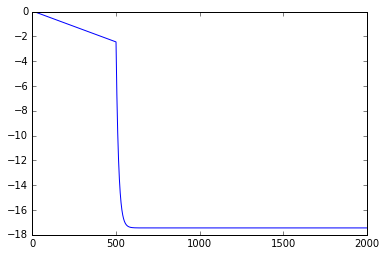

In [7]:
plt.plot(exponentiel(np.arange(2000), tau=15, maxi=15., start_anti=10, latence=500., v_anti=0.005))

/usr/local/lib/python3.5/dist-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


[[Model]]
    Model(exponentiel)
[[Fit Statistics]]
    # function evals   = 223
    # data points      = 1590
    # variables        = 5
    chi-square         = 29559.938
    reduced chi-square = 18.650
    Akaike info crit   = 4657.071
    Bayesian info crit = 4683.928
[[Variables]]
    tau:          19.7285949 +/- 5.482713 (27.79%) (init= 15)
    maxi:         10.0001069 +/- 0.885413 (8.85%) (init= 15)
    latence:      967.000682 +/- 4.044612 (0.42%) (init= 875)
    start_anti:   868.805994 +/- 50.50130 (5.81%) (init= 475)
    v_anti:       0.01719599 +/- 0.015420 (89.68%) (init= 0)
    bino:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(start_anti, v_anti)        =  0.865 
    C(maxi, v_anti)              = -0.845 
    C(tau, latence)              = -0.622 
    C(maxi, start_anti)          = -0.483 
    C(maxi, latence)             = -0.430 
    C(latence, v_anti)           =  0.365 
    C(latence, start_anti)       =  0.209 



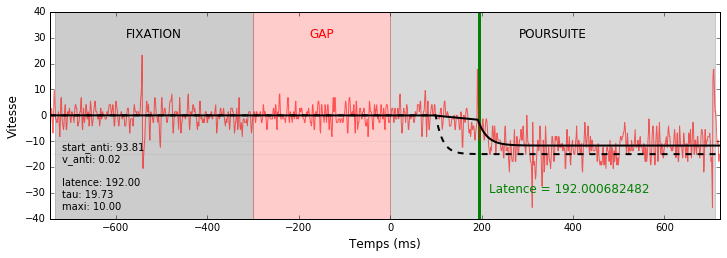

In [8]:
fig_width= 12
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))
block = 0
trial = 77


trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']

StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']
trackertime_0 = data[trial_data]['trackertime'][0]

gradient_x = np.gradient(data_x) # gradient en px/ms
gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

# SUPPRESSION DES SACCADES
new_gradient_deg=[]
new_time=[]
t=0
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
            saccade = 'yes'
    if not saccade :
        new_gradient_deg.append(gradient_deg[x_data])
        new_time.append(t)
        t = t+1
    saccade = None

StimulusOn_0 = StimulusOn
StimulusOf_0 = StimulusOf
TargetOn_0 = TargetOn
TargetOff_0 = TargetOff

for s in range(len(saccades)) :
    if StimulusOn_0 > (saccades[s][1]) :
        StimulusOn = StimulusOn - (saccades[s][2]+5)
    if StimulusOf_0 > (saccades[s][1]) :
        StimulusOf = StimulusOf - (saccades[s][2]+5)
    if TargetOn_0 > (saccades[s][1]) :
        TargetOn = TargetOn - (saccades[s][2]+5)
    if TargetOff_0 > (saccades[s][1]) :
        TargetOff = TargetOff - (saccades[s][2]+5)

start = TargetOn

StimulusOn_s = StimulusOn - start
StimulusOf_s = StimulusOf - start
TargetOn_s = TargetOn - start
TargetOff_s = TargetOff - start
trackertime_s = trackertime - start
        
# FIT
model = Model(exponentiel)
bino=p[trial, block, 0]
params = Parameters()
params.add('tau', value=15., min=10., max=70.)#, vary=False)
params.add('maxi', value=15., min=10., max=40.)#, vary=False)
params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0, max=len(new_gradient_deg))
params.add('start_anti', value=StimulusOf-trackertime_0, min=StimulusOf-trackertime_0, max=TargetOn-trackertime_0+100)
params.add('v_anti', value=0., min=-1., max=1.)

params.add('bino', value=bino, min=0, max=1, vary=False)


result_deg = model.fit(new_gradient_deg, params, x=new_time)

debut  = TargetOn - trackertime_0 # TargetOn - temps_0


axs.axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])

axs.plot(np.asarray(new_time)-debut, new_gradient_deg, color='r', alpha=0.6)
axs.plot(np.asarray(new_time)-debut, result_deg.init_fit, 'k--', linewidth=2)
axs.plot(np.asarray(new_time)-debut, result_deg.best_fit, color='k', linewidth=2)
axs.plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(bino*2-1)*15, color='k', linewidth=0.2, alpha=0.2)
axs.plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(bino*2-1)*10, color='k', linewidth=0.2, alpha=0.2)

axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)

start_anti = result_deg.values['start_anti']-debut
v_anti = result_deg.values['v_anti']
latence = result_deg.values['latence']-debut
tau = result_deg.values['tau']
maxi = result_deg.values['maxi']


axs.bar(latence, 80, bottom=-40, color='g', width=6, linewidth=0)

axs.text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 30, "FIXATION", color='k', fontsize=12, horizontalalignment='center')
axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 30, "GAP", color='r', fontsize=12, horizontalalignment='center')
axs.text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 30, "POURSUITE", color='k', fontsize=12, horizontalalignment='center')
axs.text(latence+25, -30, "Latence = %s"%(latence), color='g', fontsize=12)#,  weight='bold')
#axs.text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=10)
axs.text(StimulusOn_s+15, -36, "start_anti: %4.2f \nv_anti: %0.2f \n\nlatence: %4.2f \ntau: %0.2f \nmaxi: %0.2f"%(start_anti, v_anti, latence, tau, maxi), color='k', fontsize=10)

axs.set_xlabel('Temps (ms)', fontsize=12)
axs.set_ylabel('Vitesse', fontsize=12)

print(result_deg.fit_report())

In [9]:
liste_start_anti = []
liste_liste_v_anti = []
liste_latence = []
liste_tau = []
liste_maxi = []

for block in range(N_blocks) :
    fig_width= 12
    fig, axs = plt.subplots(N_trials, 1, figsize=(fig_width, (fig_width*(N_trials/2))/1.6180))

    block_start_anti = []
    block_liste_v_anti = []
    block_latence = []
    block_tau = []
    block_maxi = []
    
    for trial in range(N_trials) :
        
        print(block, trial)
        
        trial_data = trial + N_trials*block
        data_x = data[trial_data]['x']
        data_y = data[trial_data]['y']
        trackertime = data[trial_data]['trackertime']

        StimulusOn = data[trial_data]['events']['msg'][10][0]
        StimulusOf = data[trial_data]['events']['msg'][14][0]
        TargetOn = data[trial_data]['events']['msg'][15][0]
        TargetOff = data[trial_data]['events']['msg'][16][0]
        saccades = data[trial_data]['events']['Esac']

        trackertime_0 = data[trial_data]['trackertime'][0]

        gradient_x = np.gradient(data_x)
        gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec
        
        
        # SUPPRESSION DES SACCADES
        #new_gradient_x=[]
        new_gradient_deg=[]
        new_time=[]
        t=0
        for x_data in range(len(data_x)):
            saccade = None
            for s in range(len(saccades)) :
                if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+1+4)) :
                    saccade = 'yes'
            if not saccade :
                new_gradient_deg.append(gradient_deg[x_data])
                new_time.append(t)
                t = t+1
            saccade = None
        
        StimulusOn_0 = StimulusOn
        StimulusOf_0 = StimulusOf
        TargetOn_0 = TargetOn
        TargetOff_0 = TargetOff

        for s in range(len(saccades)) :
            if StimulusOn_0 > (saccades[s][1]) :
                StimulusOn = StimulusOn - (saccades[s][2]+5)
            if StimulusOf_0 > (saccades[s][1]) :
                StimulusOf = StimulusOf - (saccades[s][2]+5)
            if TargetOn_0 > (saccades[s][1]) :
                TargetOn = TargetOn - (saccades[s][2]+5)
            if TargetOff_0 > (saccades[s][1]) :
                TargetOff = TargetOff - (saccades[s][2]+5)

        start = TargetOn

        StimulusOn_s = StimulusOn - start
        StimulusOf_s = StimulusOf - start
        TargetOn_s = TargetOn - start
        TargetOff_s = TargetOff - start
        trackertime_s = trackertime - start
    

        # FIT
        model = Model(exponentiel)
        bino=p[trial, block, 0]
        params = Parameters()
        params.add('tau', value=15., min=10., max=70.)#, vary=False)
        params.add('maxi', value=15., min=10., max=40.)#, vary=False)
        params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0, max=len(new_gradient_deg))
        params.add('start_anti', value=StimulusOf-trackertime_0, min=StimulusOf-trackertime_0-100, max=TargetOn-trackertime_0)
        params.add('v_anti', value=0., min=-1., max=1.)
        params.add('bino', value=bino, min=0, max=1, vary=False)
        
        result_deg = model.fit(new_gradient_deg, params, x=new_time)
        
        debut  = TargetOn - trackertime_0 # TargetOn - temps_0
        
        axs[trial].cla() # pour remettre ax figure a zero
        axs[trial].axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])
        
        axs[trial].plot(np.asarray(new_time)-debut, new_gradient_deg, color='r', alpha=0.6)
        axs[trial].plot(np.asarray(new_time)-debut, result_deg.init_fit, 'k--', linewidth=2)
        axs[trial].plot(np.asarray(new_time)-debut, result_deg.best_fit, color='k', linewidth=2)
        axs[trial].plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(bino*2-1)*(15), color='k', linewidth=0.2, alpha=0.2)
        axs[trial].plot(np.asarray(new_time)-debut, np.ones(np.shape(new_time)[0])*(bino*2-1)*(10), color='k', linewidth=0.2, alpha=0.2)
        
        axs[trial].axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
        axs[trial].axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
        axs[trial].axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)

        start_anti = result_deg.values['start_anti']-debut
        v_anti = result_deg.values['v_anti']
        latence = result_deg.values['latence']-debut
        tau = result_deg.values['tau']
        maxi = result_deg.values['maxi']
        
        block_start_anti.append(start_anti)
        block_liste_v_anti.append(v_anti)
        block_latence.append(latence)
        block_tau.append(tau)
        block_maxi.append(maxi)
        
        axs[trial].bar(latence, 80, bottom=-40, color='g', width=6, linewidth=0)
        
        axs[trial].text(StimulusOn_s+(StimulusOf_s-StimulusOn_s)/2, 35, "FIXATION", color='k', fontsize=12, horizontalalignment='center')
        axs[trial].text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 35, "GAP", color='r', fontsize=12, horizontalalignment='center')
        axs[trial].text(TargetOn_s+(TargetOff_s-TargetOn_s)/2, 35, "POURSUITE", color='k', fontsize=12, horizontalalignment='center')
        axs[trial].text(latence+25, -35, "Latence = %s"%(latence), color='g', fontsize=12)#,  weight='bold')
        #axs[trial].text(StimulusOn+15, -2, "%s"%(result.fit_report()), color='k', fontsize=15)
        axs[trial].text(StimulusOn_s+15, -36, "start_anti: %s \nv_anti: %s \n\nlatence: %s \ntau: %s \nmaxi: %s"%(start_anti, v_anti, latence, tau, maxi), color='k', fontsize=12)

        
        axs[trial].set_xlabel('Time (ms)', fontsize=9)
        axs[trial].set_ylabel(trial+1, fontsize=9)

    
    liste_start_anti.append(block_start_anti)
    liste_liste_v_anti.append(block_liste_v_anti)
    liste_latence.append(block_latence)
    liste_tau.append(block_tau)
    liste_maxi.append(block_maxi)
    
    plt.tight_layout() # pour supprimer les marge trop grande
    plt.subplots_adjust(hspace=0) # pour enlever espace entre les figures

    plt.savefig('figures/Fit_anticipation_%s_%s_block-%s_exp.pdf'%(observer, timeStr, block+1))

plt.close()

param = {}
param['start_anti'] = liste_start_anti
param['v_anti'] = liste_liste_v_anti
param['latence'] = liste_latence
param['tau'] = liste_tau
param['maxi'] = liste_maxi

file = os.path.join('parametre', observer + '_param_Fit.pkl')
with open(file, 'wb') as fichier:
    f = pickle.Pickler(fichier)
    f.dump(param)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
